# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<h3>Описание данных</h3>
<div class="paragraph"><strong>Признаки</strong></div><ul><li><em>RowNumber —</em> индекс строки в данных</li><li><em>CustomerId</em> — уникальный идентификатор клиента</li><li><em>Surname —</em> фамилия</li><li><em>CreditScore —</em> кредитный рейтинг</li><li><em>Geography —</em> страна проживания</li><li><em>Gender —</em> пол</li><li><em>Age —</em> возраст</li><li><em>Tenure —</em> сколько лет человек является клиентом банка</li><li><em>Balance —</em> баланс на счёте</li><li><em>NumOfProducts —</em> количество продуктов банка, используемых клиентом</li><li><em>HasCrCard —</em> наличие кредитной карты</li><li><em>IsActiveMember —</em> активность клиента</li><li><em>EstimatedSalary —</em> предполагаемая зарплата</li></ul><div class="paragraph"><strong>Целевой признак</strong></div><ul><li><em>Exited</em> — факт ухода клиента</li></ul>

## Подготовка данных

In [1]:
# !pip install imbalanced-learn --user

In [2]:
import imblearn

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = (9,6)

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',50)

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

import numpy as np

RANDOM_STATE = 12345

import seaborn as sns
sns.set_style("whitegrid", {'figure.facecolor': '0.97',});
sns.set_palette("Set2");

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, AllKNN, RandomUnderSampler

import warnings

<Figure size 648x432 with 0 Axes>

In [4]:
#сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    #mask = np.zeros_like(corr)
    #mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:,:-1]
    mask = pd.DataFrame(mask).iloc[1:,:-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0]*1.2,(corr.shape[0]*0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_zero_plots:
        # готовим матрицу корреляций нулей
        t = df.isin([0,'0']).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 0:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isin([0,'0']).sort_values(by=list(indx))
            plt.figure(figsize=(20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())
    
    scatter_matrix = pd.plotting.scatter_matrix(
        df,
        figsize  = [16, 10],
        marker   = ".",
        s        = 2,
        alpha = 0.4,
        diagonal = "hist" # hist or kde
    )

    for ax in scatter_matrix.ravel():
        ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 20, loc='center')
        ax.set_xticklabels([])
        ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 70, loc='center', labelpad=10)
        ax.set_yticklabels([])

In [5]:
try:
    df = pd.read_csv('/datasets/Churn.csv', sep=',')
except:
    df = pd.read_csv('datasets\yandex_07_churn.csv', sep=',')



------SAMPLE--------


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6088,6089,15752912,Perkin,661,France,Female,30,7.000,0.000,2,1,0,"72,196.570",0
3270,3271,15629885,Wilson,850,France,Female,33,7.000,"118,004.260",1,1,0,"183,983.820",0
6374,6375,15807473,Morehead,503,France,Male,38,1.000,0.000,2,1,1,"95,153.240",0
8382,8383,15612594,Ifeanacho,599,Spain,Male,25,NaN,0.000,2,1,1,"120,790.020",0
7937,7938,15775886,Su,670,France,Male,36,NaN,0.000,1,1,0,"140,754.190",1



------DTYPES--------
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


------NaN & zero--------
                  NA  filled  zero   %na
RowNumber          -   10000     -     -
CustomerId         -   10000     -     -
Surname            -   10000     -     -
CreditScore        -   10000     -     -
Geography          -   10000     -     -
Gender             -   10000     -     -
Age                -   10000     -     -
Tenure           909    9091   382 9.090
Balance            -   10000  3617     -
NumOfProducts      -   10000     -     -
HasCrCard          -   10000  2945     -
IsActiveMember     -   10000  4849     -
EstimatedSalary    -   100

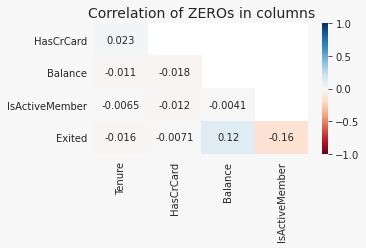

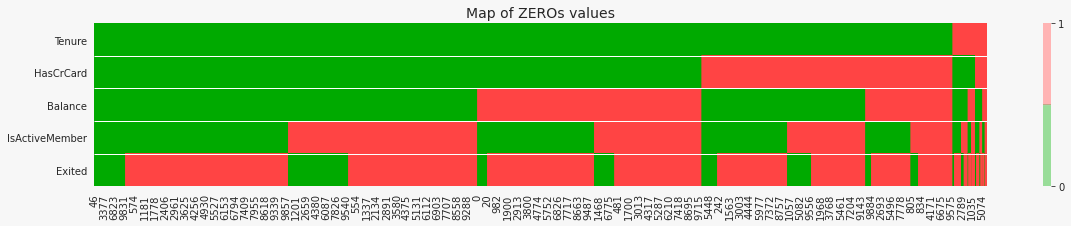

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,"10,000.000",NaN,NaN,NaN,"5,000.500","2,886.896",1.000,"2,500.750","5,000.500","7,500.250","10,000.000"
CustomerId,"10,000.000",NaN,NaN,NaN,"15,690,940.569","71,936.186","15,565,701.000","15,628,528.250","15,690,738.000","15,753,233.750","15,815,690.000"
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,"10,000.000",NaN,NaN,NaN,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,"10,000.000",NaN,NaN,NaN,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,"9,091.000",NaN,NaN,NaN,4.998,2.895,0.000,2.000,5.000,7.000,10.000
Balance,"10,000.000",NaN,NaN,NaN,"76,485.889","62,397.405",0.000,0.000,"97,198.540","127,644.240","250,898.090"
NumOfProducts,"10,000.000",NaN,NaN,NaN,1.530,0.582,1.000,1.000,1.000,2.000,4.000


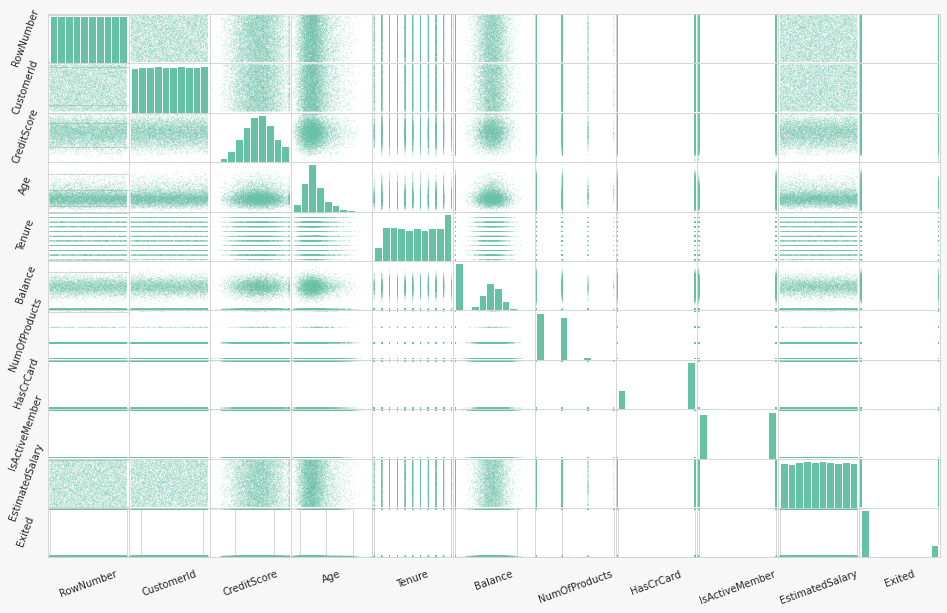

In [6]:
evaluate_df(df, True)

#### Вывод по изучению данных
1. Пропуски в Tenure 9%
2. Имеются данные, которые нужно исключить при создании модели (RowNumber, CustomerId, Surname)
3. Названия столбцов в стиле CamelCase, но это не мешает, оставим
4. столбцы Geography и Gender категориальные, имеют тип oblect. Нужно преобразовать их с OHE

#### Подготовка данных для классификации
<br>
Посмотрим на пустые и непустые Tenure

In [7]:
df[df['Tenure'].isna()].describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,909.000,NaN,NaN,NaN,"4,866.386","2,909.604",31.000,"2,311.000","4,887.000","7,306.000","10,000.000"
CustomerId,909.000,NaN,NaN,NaN,"15,689,814.576","75,112.254","15,565,806.000","15,626,578.000","15,686,870.000","15,756,804.000","15,815,690.000"
Surname,909,665,Hughes,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,909.000,NaN,NaN,NaN,648.451,99.079,359.000,580.000,647.000,718.000,850.000
Geography,909,3,France,464,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,909,2,Male,483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,909.000,NaN,NaN,NaN,38.648,9.785,18.000,32.000,37.000,43.000,92.000
Tenure,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balance,909.000,NaN,NaN,NaN,"76,117.341","63,105.691",0.000,0.000,"96,674.550","128,554.980","206,663.750"
NumOfProducts,909.000,NaN,NaN,NaN,1.530,0.588,1.000,1.000,1.000,2.000,4.000


In [8]:
df[df['Tenure'].notna()].describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,"9,091.000",NaN,NaN,NaN,"5,013.910","2,884.433",1.000,"2,521.500","5,019.000","7,511.500","9,999.000"
CustomerId,"9,091.000",NaN,NaN,NaN,"15,691,053.156","71,614.192","15,565,701.000","15,628,985.500","15,691,061.000","15,752,851.500","15,815,660.000"
Surname,9091,2787,Smith,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,"9,091.000",NaN,NaN,NaN,650.737,96.410,350.000,584.000,652.000,717.000,850.000
Geography,9091,3,France,4550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,9091,2,Male,4974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,"9,091.000",NaN,NaN,NaN,38.949,10.556,18.000,32.000,37.000,44.000,92.000
Tenure,"9,091.000",NaN,NaN,NaN,4.998,2.895,0.000,2.000,5.000,7.000,10.000
Balance,"9,091.000",NaN,NaN,NaN,"76,522.740","62,329.529",0.000,0.000,"97,318.250","127,561.890","250,898.090"
NumOfProducts,"9,091.000",NaN,NaN,NaN,1.530,0.581,1.000,1.000,1.000,2.000,4.000


Совершенно нет разницы между пустыми и непустыми Tenure. Посмотрим гистограмму

In [9]:
df[df['Tenure'].notna()]['Tenure'].value_counts()

1.000     952
2.000     950
8.000     933
3.000     928
5.000     927
7.000     925
4.000     885
9.000     882
6.000     881
10.000    446
0.000     382
Name: Tenure, dtype: int64

Какой-то равномерное распределение. Наталкивает на мысли о искуственном датасете.

Самый слабый класс Tenure = 0, поэтому присвоим пустым значениям Tenure значение 0, тем самым приблизив распределение к равномерному. Можно конечно еще дальше пойти и часть присвоить 0 а часть 10 (тоже слабый класс), но пока должно хватить и Tenure=0 всем пустым Tenure.

In [10]:
df.loc[df['Tenure'].isna(),'Tenure'] = 0

Убираем столбцы, ненужные для классификации и заменяем dummie столбцами категориальные столбы 

In [11]:
dfr = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
dfr = pd.get_dummies(dfr, drop_first=True)

Проверка. Смотрим сводную информацию о датасете


------SAMPLE--------


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
6204,498,33,1.000,"198,113.860",1,1,0,"69,664.350",0,0,0,1
3700,678,22,6.000,"118,064.930",2,1,1,"195,424.010",0,0,0,0
8276,580,32,9.000,"142,188.200",2,0,1,"128,028.600",0,0,1,1
9900,646,39,6.000,"121,681.910",2,0,1,"61,793.470",0,1,0,1
593,630,32,4.000,"82,034.000",1,0,0,"146,326.450",0,0,1,1



------DTYPES--------
CreditScore            int64
Age                    int64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Male            uint8
dtype: object


------NaN & zero--------
                  NA  filled  zero %na
CreditScore        -   10000     -   -
Age                -   10000     -   -
Tenure             -   10000  1291   -
Balance            -   10000  3617   -
NumOfProducts      -   10000     -   -
HasCrCard          -   10000  2945   -
IsActiveMember     -   10000  4849   -
EstimatedSalary    -   10000     -   -
Exited             -   10000  7963   -
Geography_Germany  -   10000  7491   -
Geography_Spain    -   10000  7523   -
Gender_Male        -   10000  4543   -


,count,mean,std,min,25%,50%,75%,max
CreditScore,"10,000.000",650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,"10,000.000",38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,"10,000.000",4.543,3.112,0.000,2.000,4.000,7.000,10.000
Balance,"10,000.000","76,485.889","62,397.405",0.000,0.000,"97,198.540","127,644.240","250,898.090"
NumOfProducts,"10,000.000",1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,"10,000.000",0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,"10,000.000",0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,"10,000.000","100,090.240","57,510.493",11.580,"51,002.110","100,193.915","149,388.247","199,992.480"
Exited,"10,000.000",0.204,0.403,0.000,0.000,0.000,0.000,1.000
Geography_Germany,"10,000.000",0.251,0.434,0.000,0.000,0.000,1.000,1.000


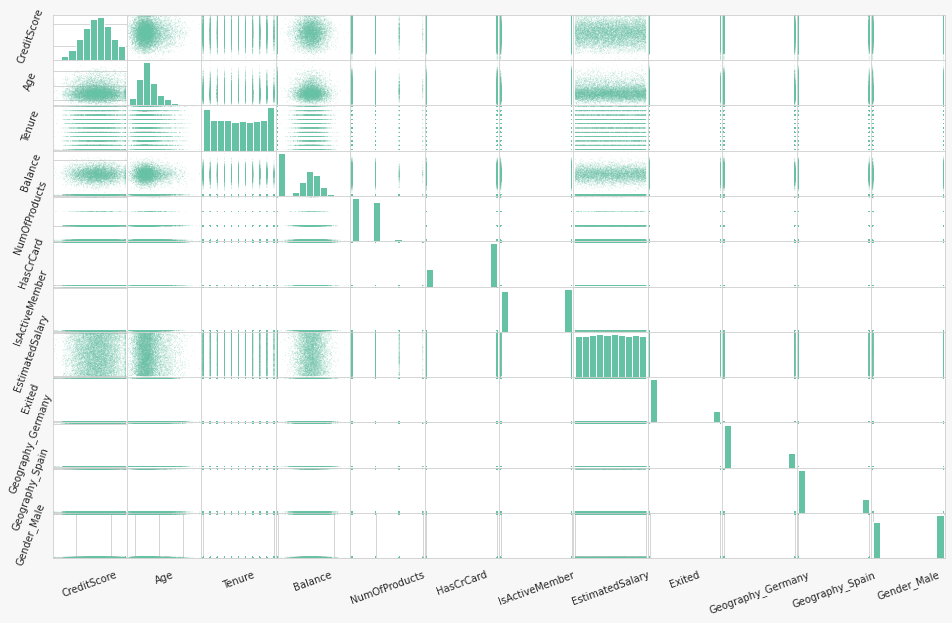

In [12]:
evaluate_df(dfr)

#### Итог
1. Пропуски в Tenure заменили на 0
2. Исключить RowNumber, CustomerId, Surname
3. столбцы Geography и Gender категориальные, их преобразовали в dummie столбцы

## Исследование задачи

Подготовим три UDF они понадобятся неоднократно для подбора гибперпараметров модели и  для вывода AUC+f1 score

In [13]:
# Массив ARR: [[X_train, y_train, 'TRAIN'], [X_valid, y_valid, 'VALID'], [X_test, y_test, 'TEST']]
def cals_metrics(model, ARR, treshold):
    data = []
    for i in range(len(ARR)):
        predictions_proba = model.predict_proba(ARR[i][0])[:,1]
        predictions = predictions_proba > treshold
        data.append([ARR[i][2], roc_auc_score(ARR[i][1], predictions_proba), f1_score(ARR[i][1], predictions, zero_division=0)])
    cm_df = pd.DataFrame(data, columns=['subset', 'roc_auc', 'f1'])
    
    display(cm_df.set_index('subset'))

In [14]:
def test_hypers(estimator_str, parameters, etalon_parameters, X_tv, y_tv):
    result_ = {}
    if estimator_str == 'GBC':
        estimator = GradientBoostingClassifier(random_state=RANDOM_STATE)
    elif estimator_str == 'RFC':
        estimator = RandomForestClassifier(random_state=RANDOM_STATE)
    elif estimator_str == 'ETC':
        estimator = ExtraTreesClassifier(random_state=RANDOM_STATE)
        
    print(etalon_parameters)
    skf = StratifiedKFold(n_splits=9, random_state=RANDOM_STATE, shuffle=True)
    figure = plt.figure(figsize=(16,10))
    i = 1
    result_
    min_f, max_f = (1,0)
    for name, p_arr in parameters.items():
        r = []
        for v in p_arr:
            param = etalon_parameters.copy()
            param[name] = v

            param['random_state'] = 42
            estimator.set_params(**param)

            cv_results = cross_validate(estimator, X_tv, y_tv, cv=skf, scoring='f1')
            result = cv_results['test_score']
            for d in result:
                r.append([v, d])
        i = i + 1
        r = np.asarray(r, dtype=object)
        result_[name] = r
        if min_f > r[:,1].min():
            min_f = r[:,1].min()
        if max_f < r[:,1].max():
            max_f = r[:,1].max()


    min_f, max_f = (min_f - 0.1*(max_f-min_f), max_f + 0.1*(max_f-min_f))

    i = 1
    for name, points in result_.items():
        ax = plt.subplot(3,len(parameters), i)
        ax.scatter(points[:, 0], points[:, 1], s=5)
        ax.set_ylim(min_f, max_f)
        ax.set_title(name)
        i += 1
    i = 1
    for name, points in result_.items():

        pdf = pd.DataFrame(points, columns=['x', 'y'])
        pdf['y'] = pdf['y'].astype('float')
        ppt = pdf.pivot_table(index='x', values='y', aggfunc=['mean', 'std']).reset_index()
        ppt.columns = ['x', 'mean', 'std']

        ax = plt.subplot(3,len(parameters), len(parameters)+i)
        ax.plot(ppt['x'], ppt['mean']-ppt['std'], label='mean-std')
        ax.plot(ppt['x'], ppt['mean'], label='mean')
        ax.plot(ppt['x'], ppt['mean']+ppt['std'], label='mean+std')
        ax.legend()
        ax.set_ylim(min_f, max_f)

        ax = plt.subplot(3,len(parameters), 2*len(parameters)+i)
        ax.plot(ppt['x'], ppt['std']/ppt['mean'], label='variation')
        ax.legend(loc='best')

        i += 1

In [15]:
# Search Function by grid of hyper params and using cross-validation and transformation train sample (under/over sampling)
def GridCVPL(transformer, classifier, parameters, X, y):
    if classifier == 'GBC':
        cls = GradientBoostingClassifier(random_state=RANDOM_STATE)
    elif classifier == 'RFC':
        cls = RandomForestClassifier(random_state=RANDOM_STATE)
    elif classifier == 'ETC':
        cls = ExtraTreesClassifier(random_state=RANDOM_STATE)

    if transformer == 'RUS':
        trns = RandomUnderSampler(random_state=RANDOM_STATE)
    elif transformer == 'ENN':
        trns = EditedNearestNeighbours(n_jobs=-1)
    elif transformer == 'AllKNN':
        trns = AllKNN(n_jobs=-1)
    elif transformer == 'TL':
        trns = TomekLinks(n_jobs=-1)
    elif transformer == 'SMOTE':
        trns = SMOTE(random_state=RANDOM_STATE)
    elif transformer == 'ADASYN':
        trns = ADASYN(random_state=RANDOM_STATE)
    elif transformer == 'ROS':
        trns = RandomOverSampler(random_state=RANDOM_STATE)
    
    classifier_str = 'classifier'
    if transformer == 'NONE':
        imba_pipeline = Pipeline([(classifier_str, cls)])
    else:
        imba_pipeline = Pipeline([('transformer', trns), (classifier_str, cls)])


    #kf = KFold(n_splits=4, random_state=None, shuffle=False)
    kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    prefix = classifier_str + '__'
    new_params = {prefix + key: parameters[key] for key in parameters}
    grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=5, scoring='f1',
                            return_train_score=False, n_jobs=-1)
    grid_imba.fit(X, y)
    
    # Check found hyper params. The params must not be on the edges of possible values.
    # This requirement lead from optimality of the params
    s = grid_imba.best_params_
    success = True
    for p,v in s.items():
        if p[len(prefix):] != 'random_state' and p[len(prefix):] != 'class_weight' and (parameters[p[len(prefix):]][-1]==v or (v>1 and parameters[p[len(prefix):]][0]==v)):
            print('Warning: best param ' + p[len(prefix):] + '='+str(v)+' is on border range. You need to set more wide range for '+p[len(prefix):])
            success = False
            break
    if success == True:
        print('Best hyper params have been found:')
        print(grid_imba.best_params_)
        print(grid_imba)
    return grid_imba.best_estimator_

Рассматрваемые модели:
- GradientBoostingClassifier (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">link</a>)
- RandomForestClassifier  (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">link</a>)
- ExtraTreesClassifier  (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html">link</a>)

Алгоритмы downsampling (under-sampling)
- RandomUnderSampler    (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html">link</a>)
- EditedNearestNeighbours    (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html">link</a>)
- AllKNN    (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.AllKNN.html">link</a>)
- TomekLinks    (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html">link</a>)

Алгоритмы upsampling (over-sampling)
- RandomOverSampler  (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html">link</a>)
- SMOTE  (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html">link</a>)
- ADASYN  (<a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html">link</a>)


Выбранные модели основаны на деревьях решений и позволяют перебирать примерно те же параметры, при этом модели не требуют масштабирования (нормирования)

Алгоритмы under-sampling и over-sampling выбраны на основании их упоминаемости в поисковиках. Просто решил попробовать и посмотреть какой покажет себя с лучшей стороны. Суть отличий алгоритмов в том, что они по-разному добавляют новые элементы в выборки, делая это так, чтобы предположительно помочь классификатору более четко разделить классы 0 и 1.

Посмотрм на баланс классов Exited (0 и 1)

In [16]:
dfr['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Видим сильный дисбаланс. класс 1 меньше класса 0 в 4 раза.

Делим выборку на 3 части: train, valid, test

Делим чтобы train+valid к test были 4:1 и чтобы train к valid была тоже 4:1. Такое решение следует из разбиения на 5 folds при CrossValidation (5 - default)

Должно получиться сотношение 16:4:5 (train:valid:test)
Это близко к классическому 3:1:1.

In [17]:
y = dfr['Exited']
X = dfr.drop(['Exited'] , axis=1)
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, shuffle = True,  random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.2, shuffle = True, random_state=RANDOM_STATE)

# Вспомогательный массив
ARR = [[X_train, y_train, 'TRAIN'], [X_valid, y_valid, 'VALID'], [X_test, y_test, 'TEST']]

In [18]:
sh_df = pd.DataFrame(data = {
    'subset':[ARR[0][2], ARR[1][2], ARR[2][2]]
    , 'X_shape':[ARR[0][0].shape, ARR[1][0].shape, ARR[2][0].shape]
    , 'y_shape':[ARR[0][1].shape, ARR[1][1].shape, ARR[2][1].shape]
    , 'y_mean':[ARR[0][1].mean(), ARR[1][1].mean(), ARR[2][1].mean()]
})
display(sh_df.set_index('subset'))

,X_shape,y_shape,y_mean
subset,,,
TRAIN,"(6400, 11)","(6400,)",0.204
VALID,"(1600, 11)","(1600,)",0.189
TEST,"(2000, 11)","(2000,)",0.213


видно, что выборки имеют размеры стандартные: 6400, 1600, 2000 (16:4:5)

Также видно, что среднее y_train около 0,2, т.е. выборки не сбалансированные

#### GradientBoostingClassifier

Перебираем гиперпараметры GradientBoostingClassifier и находим оптимальную модель

In [19]:
%%time
parameters = { 'n_estimators':np.arange(20, 121,  20), 'max_depth':np.arange(4, 7, 1)
              ,'min_samples_leaf':np.arange(3,7,1) #, 'min_samples_split':np.arange(2,6,1)
              , 'random_state':[RANDOM_STATE]}
model_0 = GridCVPL('NONE', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

Best hyper params have been found:
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100, 'classifier__random_state': 12345}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': array([4, 5, 6]),
                         'classifier__min_samples_leaf': array([3, 4, 5, 6]),
                         'classifier__n_estimators': array([ 20,  40,  60,  80, 100, 120]),
                         'classifier__random_state': [12345]},
             scoring='f1')
CPU times: user 6min 36s, sys: 164 ms, total: 6min 36s
Wall time: 6min 44s


Изучаем метрики auc и f1

In [20]:
cals_metrics(model_0, ARR, 0.5)

,roc_auc,f1
subset,,
TRAIN,0.934,0.697
VALID,0.940,0.701
TEST,0.868,0.592


Более тательно проверяем гиперпараметры, изучая их по одному (оставляя остальные неизменными)

Используем кроссвалидацию на 9 фолдов и  считая метрику auc для каждой итерации. В итоге для одного значения изменяемого гиперпараметра имеется несколько точек. по ним мы можем оценить оптимален ли гиперпараметр, насколько высока нестабильность модели. Для упрощения добавлены графики среднего с доверительным интервалом в 1 сигму (mean+/-std) и нестабильность (variation = std/mean)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 12345, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
CPU times: user 5min 54s, sys: 256 ms, total: 5min 54s
Wall time: 6min 1s


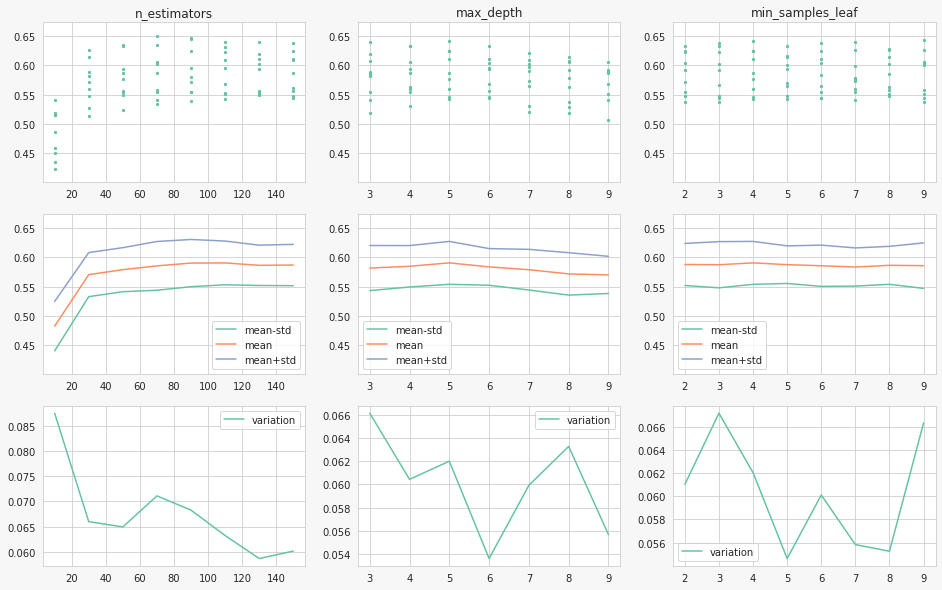

In [21]:
%%time

etalon_parameters = model_0.get_params() # {'max_depth':5, 'min_samples_leaf':5, 'n_estimators':50}
parameters = { 'n_estimators':np.arange(10, 161, 20), 'max_depth':np.arange(3, 10, 1),'min_samples_leaf':np.arange(2,10)}


test_hypers('GBC', parameters, etalon_parameters, X_tv, y_tv)

Наглядно видно, что n_estimators и max_depth оптимальны, а таже видно, что min_samples_leaf не столь критичен для модели.

<AxesSubplot:xlabel='coeff', ylabel='feature'>

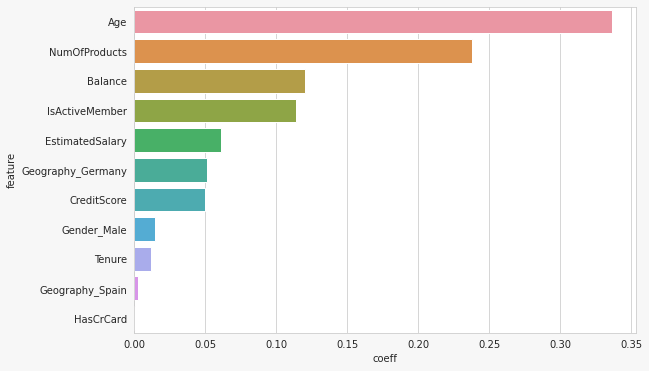

In [22]:
df_feature_importances = pd.DataFrame(((zip(X.columns, model_0.feature_importances_)))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

#### ExtraTreesClassifier

In [23]:
%%time
parameters = { 'n_estimators':np.arange(140, 311, 20), 'max_depth':np.arange(11, 20, 2),'min_samples_leaf':np.arange(1,3), 'random_state':[RANDOM_STATE]}
model_1 = GridCVPL('NONE', 'ETC', parameters, X_tv, y_tv).named_steps['classifier']
cals_metrics(model_1, ARR, 0.5)

Best hyper params have been found:
{'classifier__max_depth': 17, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 160, 'classifier__random_state': 12345}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        ExtraTreesClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': array([11, 13, 15, 17, 19]),
                         'classifier__min_samples_leaf': array([1, 2]),
                         'classifier__n_estimators': array([140, 160, 180, 200, 220, 240, 260, 280, 300]),
                         'classifier__random_state': [12345]},
             scoring='f1')


,roc_auc,f1
subset,,
TRAIN,1.000,0.984
VALID,1.000,0.987
TEST,0.850,0.520


CPU times: user 10min 1s, sys: 2.24 s, total: 10min 4s
Wall time: 10min 13s


In [24]:
model_1.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 17,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 160,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 17, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 160, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
CPU times: user 4min 15s, sys: 2.46 s, total: 4min 17s
Wall time: 4min 18s


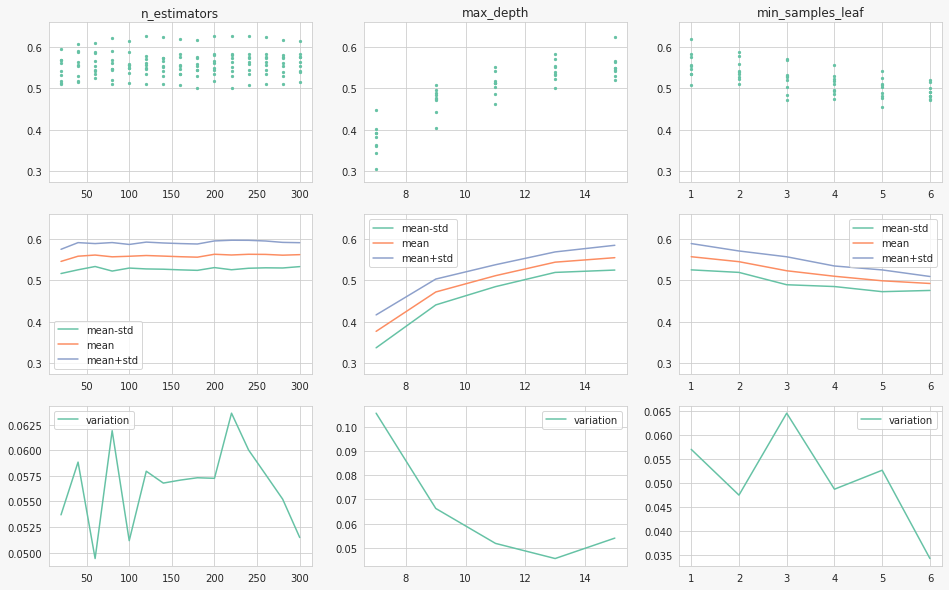

In [25]:
%%time

etalon_parameters = model_1.get_params() #{'max_depth':11, 'min_samples_leaf':1, 'n_estimators':210}
parameters = { 'n_estimators':np.arange(20, 311, 20), 'max_depth':np.arange(7, 16, 2),'min_samples_leaf':np.arange(1,7)}

test_hypers('ETC', parameters, etalon_parameters, X_tv, y_tv)

<AxesSubplot:xlabel='coeff', ylabel='feature'>

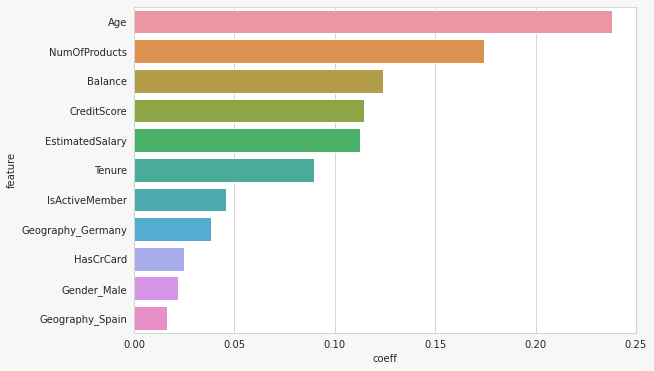

In [26]:
df_feature_importances = pd.DataFrame(((zip(X.columns, model_1.feature_importances_)))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

#### RandomForestClassifier

In [27]:
%%time
parameters = { 'n_estimators':np.arange(5, 31, 5), 'max_depth':np.arange(20,41,5)
              ,'min_samples_leaf':np.arange(1,6), 'random_state':[RANDOM_STATE]}
#model_2 = find_best_model_GS('RFC', X_tv, y_tv, parameters)
model_2 = GridCVPL('NONE', 'RFC', parameters, X_tv, y_tv).named_steps['classifier']
cals_metrics(model_2, ARR, 0.5)


Best hyper params have been found:
{'classifier__max_depth': 25, 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 20, 'classifier__random_state': 12345}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': array([20, 25, 30, 35, 40]),
                         'classifier__min_samples_leaf': array([1, 2, 3, 4, 5]),
                         'classifier__n_estimators': array([ 5, 10, 15, 20, 25, 30]),
                         'classifier__random_state': [12345]},
             scoring='f1')


,roc_auc,f1
subset,,
TRAIN,0.989,0.796
VALID,0.987,0.796
TEST,0.860,0.570


CPU times: user 2min 6s, sys: 328 ms, total: 2min 6s
Wall time: 2min 6s


In [28]:
model_2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
CPU times: user 53 s, sys: 184 ms, total: 53.1 s
Wall time: 54.4 s


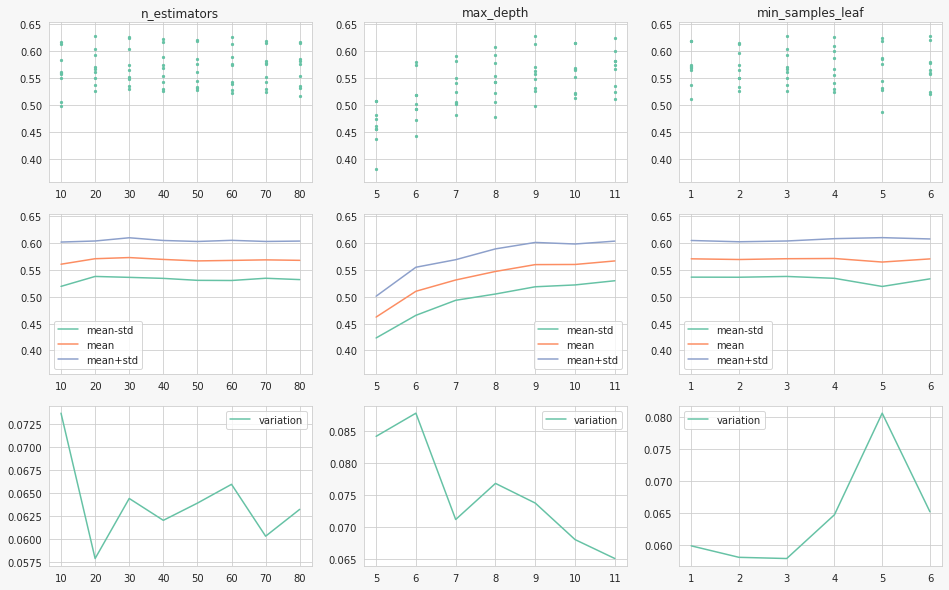

In [29]:
%%time

etalon_parameters = model_2.get_params()
parameters = { 'n_estimators':np.arange(10, 81, 10), 'max_depth':np.arange(5, 12, 1),'min_samples_leaf':np.arange(1,7)}

test_hypers('RFC', parameters, etalon_parameters, X_tv, y_tv)

<AxesSubplot:xlabel='coeff', ylabel='feature'>

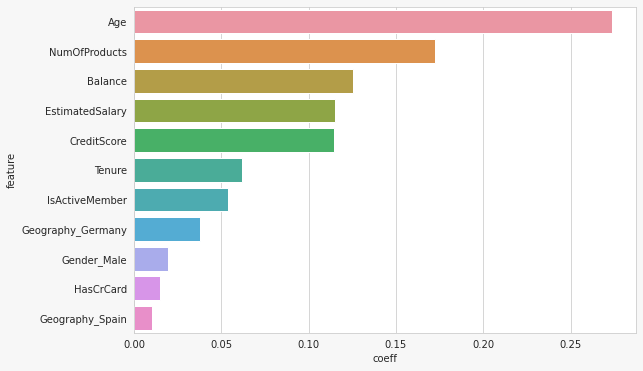

In [30]:
df_feature_importances = pd.DataFrame(((zip(X.columns, model_2.feature_importances_)))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

#### Выводы
Попробовали подобрать гиперпараметры и обучить модели RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier<br>
Ни одна из продвинутых моделей не смогла достичь нужного уровня f1=0.59. Нужно бороться с дисбалансом классов

Из наблюдений:
- Параметры моделей разные, несмотря на схожесть основных параметров RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
- Лучше всех смотрится GradientBoostingClassifier



## Борьба с дисбалансом

Будем пробовать 4 стратегии:
1. подбирать на train оптимальный threshold и применять его на valid и test
2. Делать downsampling
3. Делать upsampling
4. Делать balanced модель

### TRESHOLD

Сделаем функию, которая подбираем оптимальный threshold, а заодно и построит красивые графики 
* ROC,
* Recall Precision curve, 
*recall vs threshold, 
*precision vs threshold, 
*f1 vs threshold, 
*balanced_precision vs threshold

In [31]:
def evaluate_RPC_ROC(model, X, y, show_plots=True):
    # prepare data for plots
    probs = model.predict_proba(X)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y, preds)
    
    # create plots
    if show_plots:
        fig = plt.figure(figsize=(16, 15), dpi=80)
        gs = GridSpec(2, 2, figure=fig)

        ax00 = fig.add_subplot(gs[0, 0])
        ax00.plot(recall, precision)
        ax00.set_xlabel("recall")
        ax00.set_ylabel("precision")
        ax00.set_title("Recall Precision curve")
        ax01 = fig.add_subplot(gs[0, 1])
        ax01.plot(thresholds, precision[:-1], label='precision')
        ax01.plot(thresholds, recall[:-1], label='recall')
        ax01.plot(thresholds, 2*recall[:-1]*precision[:-1]/(precision[:-1]+recall[:-1]), label='F1')
        ax01.set_xlabel("thresholds")
        
        ax10 = fig.add_subplot(gs[1, 0])
        ax10.plot(fpr, tpr)
        ax10.set_xlabel("fpr")
        ax10.set_ylabel("tpr")
        ax10.set_title(f"ROC curve (AUC={roc_auc:.3f})")
        threshold[0]=1
        ax01.plot(threshold, 0.5*(tpr+1-fpr), label='balanced acc')
        #ax01.plot(threshold,(1/fpr-1)/(1/tpr-1), label='DOR')
        
        ax11 = fig.add_subplot(gs[1, 1])
        ax11.plot(threshold, fpr, label='fpr')
        ax11.plot(threshold, tpr, label='tpr')
        ax11.set_xlabel("threshold")
        ax01.legend()
        ax11.legend()
#         ax2 = fig.add_subplot(gs[2, :])
#         ax2.hist(probs[:,1], bins=50, density=True, alpha=0.5, color='g')
#         ax2.hist(probs[:,0], bins=50, density=True, alpha=0.5, color='r')

        plt.show()
    
    # calc optimal treshold
    for i in range(len(thresholds)):
        if precision[i] >= recall[i]:
            opt_treshold = thresholds[i]
            break

    print('opt_treshold', opt_treshold)
    return opt_treshold

#### Модель GradientBoostingClassifier

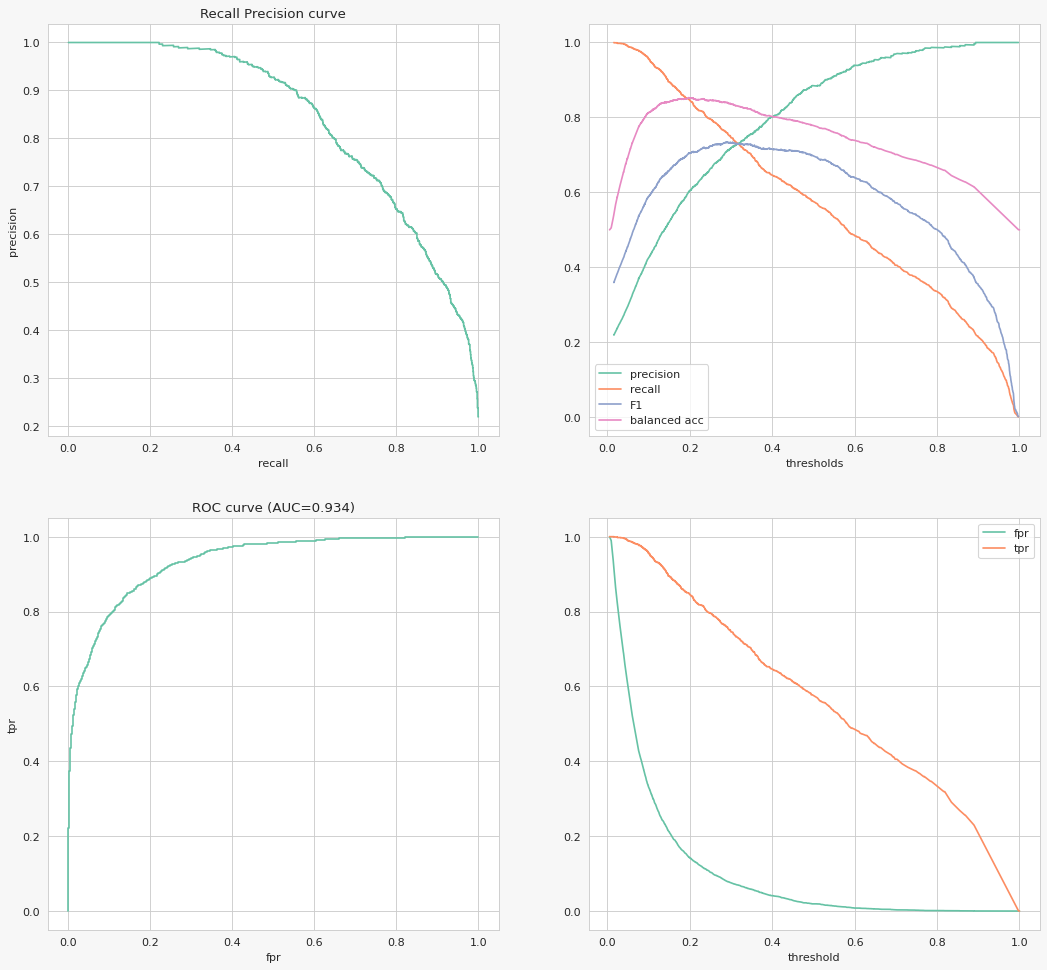

opt_treshold 0.3173301499448187


In [32]:
opt_treshold = evaluate_RPC_ROC(model_0, X_train, y_train)

посчитаем метрики для оптмального порога

In [33]:
cals_metrics(model_0, ARR, opt_treshold )

,roc_auc,f1
subset,,
TRAIN,0.934,0.729
VALID,0.940,0.719
TEST,0.868,0.651


Уже на тесте 0.65, что существенно больше цели 0.59

#### Модель ExtraTreesClassifier

In [34]:
opt_treshold = evaluate_RPC_ROC(model_1, X_train, y_train, False)
cals_metrics(model_1, ARR, opt_treshold )

opt_treshold 0.33498085034888664


,roc_auc,f1
subset,,
TRAIN,1.000,0.995
VALID,1.000,0.993
TEST,0.850,0.598


#### Модель RandomForestClassifier

In [35]:
opt_treshold = evaluate_RPC_ROC(model_2, X_train, y_train, False)
cals_metrics(model_2, ARR, opt_treshold )

opt_treshold 0.35500000000000004


,roc_auc,f1
subset,,
TRAIN,0.989,0.884
VALID,0.987,0.863
TEST,0.860,0.629


### DOWNSAMPLING

Будем пользоваться уже созданной UDF: GridCVPL

В качестве transformer передавая название способа under-sampling из imblearn

#### Random Under-Sample

In [36]:
%%time
parameters = { 'n_estimators':np.arange(20, 101, 20), 'max_depth':np.arange(2, 6, 1), 'min_samples_leaf':np.arange(5,15,2)}
# {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 11, 'classifier__n_estimators': 80}
model_RUS_GBC = GridCVPL('RUS', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

Best hyper params have been found:
{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 11, 'classifier__n_estimators': 80}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        RandomUnderSampler(random_state=12345)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': array([2, 3, 4, 5]),
                         'classifier__min_samples_leaf': array([ 5,  7,  9, 11, 13]),
                         'classifier__n_estimators': array([ 20,  40,  60,  80, 100])},
             scoring='f1')
CPU times: user 2min 26s, sys: 79.9 ms, total: 2min 26s
Wall time: 2min 29s


In [37]:
model_RUS_GBC.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 11,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_iter_no_change': None,
 'random_state': 12345,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [38]:
model = model_RUS_GBC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

,roc_auc,f1
subset,,
TRAIN,0.881,0.620
VALID,0.884,0.604
TEST,0.874,0.620



opt_treshold 0.6529653548379875


,roc_auc,f1
subset,,
TRAIN,0.881,0.631
VALID,0.884,0.651
TEST,0.874,0.649


#### Edited Nearest Neighbours

In [39]:
%%time
parameters = { 'n_estimators':np.arange(20, 101, 20), 'max_depth':np.arange(2, 6, 1), 'min_samples_leaf':np.arange(2,32,5)}
# {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 17, 'classifier__n_estimators': 80}
model_ENN_GBC = GridCVPL('ENN', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

Best hyper params have been found:
{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 17, 'classifier__n_estimators': 80}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        EditedNearestNeighbours(n_jobs=-1)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': array([2, 3, 4, 5]),
                         'classifier__min_samples_leaf': array([ 2,  7, 12, 17, 22, 27]),
                         'classifier__n_estimators': array([ 20,  40,  60,  80, 100])},
             scoring='f1')
CPU times: user 5min 44s, sys: 496 ms, total: 5min 45s
Wall time: 5min 49s


In [40]:
model_ENN_GBC.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_iter_no_change': None,
 'random_state': 12345,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [41]:
model = model_ENN_GBC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

,roc_auc,f1
subset,,
TRAIN,0.878,0.637
VALID,0.882,0.635
TEST,0.876,0.644



opt_treshold 0.4887169361503977


,roc_auc,f1
subset,,
TRAIN,0.878,0.640
VALID,0.882,0.628
TEST,0.876,0.652


#### TomekLinks

In [42]:
%%time
parameters = { 'n_estimators':np.arange(20, 201, 40), 'max_depth':np.arange(2, 10, 2), 'min_samples_leaf':np.arange(2,30,5)}
model_TL_GBC = GridCVPL('TL', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

Best hyper params have been found:
{'classifier__max_depth': 6, 'classifier__min_samples_leaf': 17, 'classifier__n_estimators': 100}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer', TomekLinks(n_jobs=-1)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': array([2, 4, 6, 8]),
                         'classifier__min_samples_leaf': array([ 2,  7, 12, 17, 22, 27]),
                         'classifier__n_estimators': array([ 20,  60, 100, 140, 180])},
             scoring='f1')
CPU times: user 14min 3s, sys: 236 ms, total: 14min 3s
Wall time: 14min 10s


In [43]:
model_TL_GBC.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 12345,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [44]:
model = model_TL_GBC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

,roc_auc,f1
subset,,
TRAIN,0.948,0.739
VALID,0.951,0.735
TEST,0.870,0.630



opt_treshold 0.358621747457633


,roc_auc,f1
subset,,
TRAIN,0.948,0.760
VALID,0.951,0.762
TEST,0.870,0.653


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 17, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_iter_no_change': None, 'random_state': 12345, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
CPU times: user 2min 21s, sys: 99.9 ms, total: 2min 21s
Wall time: 2min 24s


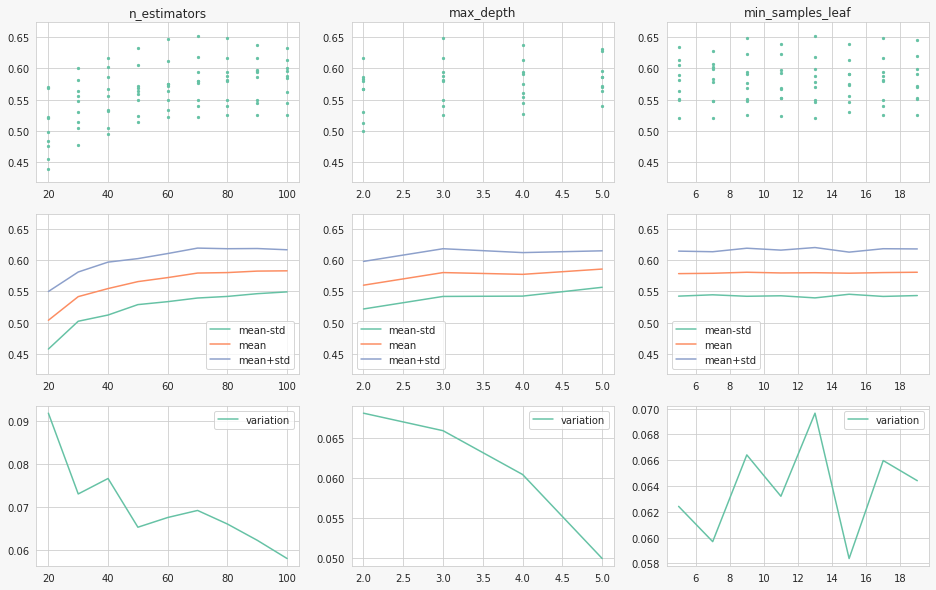

In [45]:
%%time

etalon_parameters = model_ENN_GBC.get_params()
parameters = { 'n_estimators':np.arange(20, 101, 10), 'max_depth':np.arange(2, 6, 1), 'min_samples_leaf':np.arange(5,20,2)}

test_hypers('GBC', parameters, etalon_parameters, X_tv, y_tv)

### UPSAMPLE

Будем пользоваться уже созданной UDF: GridCVPL

В качестве transformer передавая название способа over-sampling из imblearn

#### Random Over Sampler

In [ ]:
%%time
parameters = { 'n_estimators':np.arange(20, 221, 50), 'max_depth':np.arange(3, 7, 1), 'min_samples_leaf':np.arange(11,16,2)}
# {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 13, 'classifier__n_estimators': 170}
model_ROS_GBC = GridCVPL('ROS', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

In [ ]:
model_ROS_GBC.get_params()

In [ ]:
model = model_ROS_GBC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

#### SMOTE

In [ ]:
%%time
parameters = { 'n_estimators':np.arange(260, 301, 20), 'max_depth':np.arange(2, 5, 1), 'min_samples_leaf':np.arange(1,8,2)}
# {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 280}
model_SMOTE_GBC = GridCVPL('SMOTE', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

In [ ]:
model_SMOTE_GBC.get_params()

In [ ]:
model = model_SMOTE_GBC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

#### ADASYN

In [ ]:
%%time
parameters = { 'n_estimators':np.arange(20, 151, 40), 'max_depth':np.arange(2, 9, 2), 'min_samples_leaf':np.arange(1,8,2)}
# {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 100}
model_ADASYN_GBC = GridCVPL('ADASYN', 'GBC', parameters, X_tv, y_tv).named_steps['classifier']

In [ ]:
model = model_ADASYN_GBC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

### BALANCED

Проверим балансирование при подборе модели.

Перебираем гиперпараметры RandomForestClassifier и находим оптимальную модель

In [ ]:
%%time
parameters = { 'n_estimators':np.arange(50, 151, 20), 'max_depth':np.arange(3, 13, 1),'min_samples_leaf':np.arange(1,11,2),
                  'random_state':[RANDOM_STATE], 'class_weight':['balanced']}
model_BL_RFC = GridCVPL('NONE', 'RFC', parameters, X_tv, y_tv).named_steps['classifier']

In [ ]:
model = model_BL_RFC
cals_metrics(model, ARR, 0.5)
print()
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], False)
cals_metrics(model, ARR, opt_treshold)

In [ ]:
opt_treshold = evaluate_RPC_ROC(model, ARR[0][0], ARR[0][1], True)

### Выводы

1. На тестовой выборке не производили никаких манипуляций и получили следующие результаты f1,<br>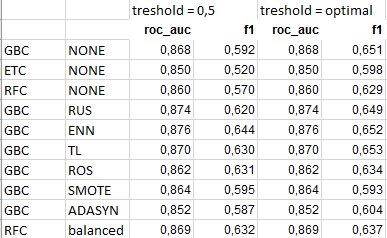<br>Тут используются сокращенные названия методов трансформаии и классификации. Соответствия можно посмотреть в UDF GridCVPL
2. При изменении treshold изменяется f1, но не изменяется auc
3. Моделям с лучшими f1 соответствуют лучшие auc. Зависимость прослеживается только при подборе оптимального treshold и до определенного предела, далее рост auc не приводит к росту f1
4. при подборе оптимального treshold не обязательно это приведет к максимзации score на test выборке. SMOTE oversampling и weights=balanced показали, что выбор оптимального treshold может привести к незначительному снижению целевой метрики на test

## Итоговый вывод

В ходе проекта были исследованы данные из «Бета-Банка». Перед анализом были заполнены пропуски и удалены неинформативные признаки. В ходе анализа было построено несколько моделей (GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier), оказалось, что уже без тюнинга GradientBoostingClassifier пробивает 0,59, показав f1=0.592
в данных был очевиден дисбаланс классов, поэтому были исследованы методы борьбы с дисбалансом такие как: подбор оптмального порога, 3 метода downsampling и 3 метода upsampling из библиотеки imblearn, балансирование классов

В итоге лучшая модель показала уровень 
- f1=0.652 для модели GradientBoostingClassifier с downsampling Edited Nearest Neighbours и подбором оптимального treshold
- f1=0.653 для модели GradientBoostingClassifier с downsampling Tomek Links и подбором оптимального treshold

В ходе работы над проектом увидел еще точки роста: сделать разбиение на выборки стратифицированным и не разбивать на train и valid. Стратификация позволит получить более стабильные модели, слабо зависящие от параметра рандомизации при разбиении

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*